[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/neuromatch/climate-course-content/blob/main/tutorials/W1D5_ClimateModeling/W1D5_Tutorial7.ipynb) &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/neuromatch/climate-course-content/main/tutorials/W1D5_ClimateModeling/W1D5_Tutorial7.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

# Tutorial 7: Introduction to Earth System Models


**Week 1, Day 5, Climate Modeling**

**Content creators:** Brodie Pearson, Jenna Pearson, Julius Busecke, and Tom Nicholas

**Content reviewers:** Yunlong Xu, Will Gregory, Peter Ohue, Derick Temfack, Zahra Khodakaramimaghsoud, Peizhen Yang, Younkap Nina Duplex, Ohad Zivan, Chi Zhang

**Content editors:** Abigail Bodner, Ohad Zivan, Chi Zhang

**Production editors:** Wesley Banfield, Jenna Pearson, Chi Zhang, Ohad Zivan

**Our 2023 Sponsors:** NASA TOPS, Google DeepMind, and CMIP



# Tutorial Objectives

In this tutorial students will learn how to load, visualize, and manipulate data from an Earth System Model (ESM) to explore the spatial variations in each component of the surface heat flux.

By the end of this tutorial students will be able to:
* Load data from the Community Earth System Model (CESM), which was used in the most recent [Coupled Model Intercomparison Project (CMIP6)](https://wcrp-cmip.org/cmip-phase-6-cmip6/)
* Analyze the zonal-mean surface energy budget of a realistic climate model (i.e., the budget at each latitude)
* Link variations in different surface heat flux to physical differences in the air-surface conditions across regions.


# Setup

In [1]:
# installations ( uncomment and run this cell ONLY when using google colab or kaggle )

# note the conda install takes quite a while, but conda is REQUIRED to properly download the
# dependencies (that are not just python packages)

# !pip install condacolab &> /dev/null
# import condacolab
# condacolab.install()

# crucial to install all packages in one line, otherwise code will fail.
# !mamba install xarray-datatree intake-esm gcsfs xmip aiohttp cartopy nc-time-axis cf_xarray xarrayutils &> /dev/null

In [2]:
# imports

# google colab users, if you get an error please run this cell again

import intake
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

from xmip.preprocessing import combined_preprocessing
from xarrayutils.plotting import shaded_line_plot
from xmip.utils import google_cmip_col

from datatree import DataTree
from xmip.postprocessing import _parse_metric

import cartopy.crs as ccrs

In [3]:
# @title Figure Settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle")

In [4]:
# @title Video 1: Introduction to Earth System Models

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'e3O9DmhE46Y'), ('Bilibili', 'BV1qh4y1G7EC')]
tab_contents = display_videos(video_ids, W=730, H=410)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [5]:
# @markdown
from ipywidgets import widgets
from IPython.display import IFrame

link_id = "dn8hs"

download_link = f"https://osf.io/download/{link_id}/"
render_link = f"https://mfr.ca-1.osf.io/render?url=https://osf.io/{link_id}/?direct%26mode=render%26action=download%26mode=render"
# @markdown
out = widgets.Output()
with out:
    print(f"If you want to download the slides: {download_link}")
    display(IFrame(src=f"{render_link}", width=730, height=410))
display(out)

Output()

# Section 1: The Community Earth System Model (CESM)

Throughout today's tutorials, we have been working with increasingly complex climate models. In this final tutorial we will look at data from the most complex type of climate model, an Earth System Model (ESM). These ESMs include the physical processes typical of General Circulation Models (GCMs), but also include chemical and biological changes within the climate system (e.g. changes in vegetation, biomes, atmospheric $CO_2$).

The [Community Earth System Model](https://www.cesm.ucar.edu/models/cesm2) (**CESM**) is the specific ESM that we will analyze here in prepartion for next week where you will look at many ESM data sets simultaneously. We will be analyzing a **historical simulation** of CESM, which covers the period 1850 to 2015 using the historicallly observed forcing of the climate system.





## Section 1.1: Finding & Opening CMIP6 Data with Xarray

Massive projects like [CMIP6](https://wcrp-cmip.org/cmip-phase-6-cmip6/) can contain millions of datasets. For most practical applications we only need a subset of the data, which we can select by specifying exactly which data sets we need. The naming conventions of CMIP6 data sets are standardized across all models and experiments, which allows us to load multiple related data sets with efficient code.

In order to load a CMIP6 dataset the following information must be specified:
1. ***variable_id***: The variable(s) of interest  
   * in CMIP6 SST is called *tos*
2. ***source_id***: The CMIP6 model(s) that we want data from 
3. ***table_id***: The origin system and output frequency desired of the variable(s) 
   * We use *Omon* - data from the ocean model at monthly resolution
4. ***grid_id***: The grid that we want the data to be on
   * We use *gn*  which is data on the model's *native* grid, some models also provide *gr* (*regridded* data) and other grid options
5. ***experiment_id***: The CMIP6 experiments that we want to analyze
   * We will load three experiments: *historical*, *ssp126* and *ssp585*. We'll discuss these more in the next few tutorials
6. ***member_id***: this distinguishes simulations if the same model is run repeatedly for an experiment
   * We use *r1i1p1f1* for now, but will explore this in a later tutorial

Each of these terms is called a *facet* in CMIP vocabulary. To learn more about CMIP and the possible facets please see our [CMIP Resource Bank](https://github.com/ClimateMatchAcademy/course-content/blob/main/tutorials/CMIP/CMIP_resource_bank.md) and the [CMIP website](https://wcrp-cmip.org/).

Once you have defined the facets of interest you need to somehow search and retrieve the datasets that contain these facets. 

There are many ways to do this, but here we will show a workflow using an [intake-esm](https://intake-esm.readthedocs.io/en/stable/) catalog object based on a CSV file that is maintained by the pangeo community. Additional methods to access CMIP data are discussed in our [CMIP Resource Bank](https://github.com/ClimateMatchAcademy/course-content/blob/main/tutorials/CMIP/CMIP_resource_bank.md).

In [6]:
col = intake.open_esm_datastore(
    "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
)  # open an intake catalog containing the Pangeo CMIP cloud data
col

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,700
grid_label,10
zstore,514818
dcpp_init_year,60


In [24]:
col.df['source_id'].unique()

array(['CMCC-CM2-HR4', 'EC-Earth3P-HR', 'HadGEM3-GC31-MM',
       'HadGEM3-GC31-HM', 'HadGEM3-GC31-LM', 'EC-Earth3P', 'ECMWF-IFS-HR',
       'ECMWF-IFS-LR', 'HadGEM3-GC31-LL', 'CMCC-CM2-VHR4', 'GFDL-CM4',
       'GFDL-AM4', 'IPSL-CM6A-LR', 'E3SM-1-0', 'CNRM-CM6-1', 'GFDL-ESM4',
       'GFDL-ESM2M', 'GFDL-CM4C192', 'GFDL-OM4p5B', 'GISS-E2-1-G',
       'GISS-E2-1-H', 'CNRM-ESM2-1', 'BCC-CSM2-MR', 'BCC-ESM1', 'MIROC6',
       'AWI-CM-1-1-MR', 'EC-Earth3-LR', 'IPSL-CM6A-ATM-HR', 'CESM2',
       'CESM2-WACCM', 'CNRM-CM6-1-HR', 'MRI-ESM2-0', 'SAM0-UNICON',
       'GISS-E2-1-G-CC', 'UKESM1-0-LL', 'EC-Earth3', 'EC-Earth3-Veg',
       'FGOALS-f3-L', 'CanESM5', 'CanESM5-CanOE', 'INM-CM4-8',
       'INM-CM5-0', 'NESM3', 'MPI-ESM-1-2-HAM', 'CAMS-CSM1-0',
       'MPI-ESM1-2-LR', 'MPI-ESM1-2-HR', 'MRI-AGCM3-2-H', 'MRI-AGCM3-2-S',
       'MCM-UA-1-0', 'INM-CM5-H', 'KACE-1-0-G', 'NorESM2-LM',
       'FGOALS-f3-H', 'FGOALS-g3', 'MIROC-ES2L', 'FIO-ESM-2-0', 'NorCPM1',
       'NorESM1-F', 'MPI-ESM1-2-XR'

We just loaded the full collection of Pangeo cloud datasets into an intake catalog, including all available models (`'source_id'`). You could try running `col.df['source_id'].unique()` in a new cell to get a list of all available models

Now we will create a subset according to the provided facets using the `.search()` method, and finally open the cloud-stored [zarr stores]() into Xarray datasets. 

The data returned are Xarray datasets which contain [dask arrays](https://docs.dask.org/en/stable/array.html). These are 'lazy', meaning the actual data will only be loaded when a computation is performed. What is loaded here is only the metadata, which enables us to inspect the data (e.g. the dimensionality/variable units) without loading in GBs or TBs of data!

A subtle but important step in the opening stage is the use of a preprocessing function! By passing `preprocess=combined_preprocessing` we apply crowdsourced fixes from the [xMIP](https://github.com/jbusecke/xmip) package to each dataset. This ensures consistent naming of dimensions (and other convienient things - see [here](https://cmip6-preprocessing.readthedocs.io/en/latest/tutorial.html) for more).

In [25]:
# from the full `col` object, create a subset using facet search
cat = col.search(
    source_id="CESM2",
    variable_id=[
        "hfls",
        "hfss",
        "rlds",
        "rlus",
        "rsds",
        "rsus",
        "tas",
        "rsdt",
        "rsut",
        "rlut",
    ],
    member_id="r1i1p1f1",
    table_id="Amon",
    grid_label="gn",
    experiment_id=["historical", "hist-nat"],
    require_all_on=[
        "source_id"
    ],  # make sure that we only get models which have all of the above experiments
)

# convert the sub-catalog into a datatree object, by opening each dataset into an Xarray.Dataset (without loading the data)
kwargs = dict(
    preprocess=combined_preprocessing,  # apply xMIP fixes to each dataset
    xarray_open_kwargs=dict(
        use_cftime=True
    ),  # ensure all datasets use the same time index
    storage_options={
        "token": "anon"
    },  # anonymous/public authentication to google cloud storage
)

cat.esmcat.aggregation_control.groupby_attrs = ["source_id", "experiment_id"]
dt = cat.to_datatree(**kwargs)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'source_id/experiment_id'


## Section 1.2: Checking the CMIP6 Datasets

We now have a "[datatree](https://xarray-datatree.readthedocs.io/en/latest/quick-overview.html)" containing the data we searched for. A datatree is a high-level container of Xarray data, useful for organizing many related datasets together. You can think of a single `DataTree` object as being like a (nested) dictionary of `xarray.Dataset` objects. Each dataset in the tree is known as a "node" or "group", and we can also have empty nodes. You can explore the nodes of the tree and its contents interactively in a similar way to how you can explore the contents of an `xarray.Dataset`. Click on the arrows to expand the information about the datatree below:

In [26]:
dt

DataTree('None', parent=None)
└── DataTree('CESM2')
    ├── DataTree('hist-nat')
    │       Dimensions:         (member_id: 1, dcpp_init_year: 1, time: 1980, y: 192,
    │                            x: 288, nbnd: 2)
    │       Coordinates:
    │         * y               (y) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    │         * x               (x) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
    │         * time            (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
    │           lon_bounds      (x, nbnd, y) float64 dask.array<chunksize=(288, 2, 192), meta=np.ndarray>
    │           lat_bounds      (y, nbnd, x) float64 dask.array<chunksize=(192, 2, 288), meta=np.ndarray>
    │           time_bounds     (time, nbnd) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
    │         * nbnd            (nbnd) int64 0 1
    │           lon             (x, y) float64 360.0 360.0 360.0 360.0 ... 358.8 358.8 358.8
    │           lat             (x, y) float64 -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
    │         * member_id       (member_id) object 'r1i1p1f1'
    │         * dcpp_init_year  (dcpp_init_year) float64 nan
    │       Data variables:
    │           hfls            (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 586, 192, 288), meta=np.ndarray>
    │           hfss            (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 577, 192, 288), meta=np.ndarray>
    │           rlds            (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 699, 192, 288), meta=np.ndarray>
    │           rlus            (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 716, 192, 288), meta=np.ndarray>
    │           rlut            (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 714, 192, 288), meta=np.ndarray>
    │           rsds            (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 672, 192, 288), meta=np.ndarray>
    │           rsdt            (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 981, 192, 288), meta=np.ndarray>
    │           rsus            (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 698, 192, 288), meta=np.ndarray>
    │           rsut            (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 663, 192, 288), meta=np.ndarray>
    │           tas             (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 813, 192, 288), meta=np.ndarray>
    │       Attributes: (12/54)
    │           Conventions:                      CF-1.7 CMIP-6.2
    │           activity_id:                      DAMIP
    │           branch_method:                    standard
    │           branch_time_in_child:             674885.0
    │           branch_time_in_parent:            306600.0
    │           case_id:                          1479
    │           ...                               ...
    │           intake_esm_attrs:member_id:       r1i1p1f1
    │           intake_esm_attrs:table_id:        Amon
    │           intake_esm_attrs:grid_label:      gn
    │           intake_esm_attrs:version:         20190730
    │           intake_esm_attrs:_data_format_:   zarr
    │           intake_esm_dataset_key:           CESM2/hist-nat
    └── DataTree('historical')
            Dimensions:         (member_id: 1, dcpp_init_year: 1, time: 1980, y: 192,
                                 x: 288, nbnd: 2)
            Coordinates:
              * y               (y) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
              * x               (x) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
              * time            (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
                lon_bounds      (x, nbnd, y) float64 dask.array<chunksize=(288, 2, 192), meta=np.ndarray>
                lat_bounds

Each group in the tree is stored under a corresponding `name`, and we can select nodes via their name. The real usefulness of a datatree comes from having many groups at different depths, analogous to how one might store files in nested directories (e.g. `day1/experiment1/data.txt`, `day1/experiment2/data.txt` etc.). 

In our case the particular datatree object has different CMIP models and different experiments stored at distinct levels of the tree. This is useful because we can select just one experiment for one model, or all experiments for one model, or all experiments for all models!

We can also apply Xarray operations (e.g. taking the average using the `.mean()` method) over all the data in a tree at once, just by calling that same method on the `DataTree` object. We can even map custom functions over all nodes in the tree using [`dt.map_over_subtree(my_function)`](https://xarray-datatree.readthedocs.io/en/latest/generated/datatree.map_over_subtree.html#datatree-map-over-subtree).

All the operations below can be accomplished without using datatrees, but it saves us many lines of code as we don't have to use `for` loops over all our the different datasets. For more information about datatree see the [documentation here](https://xarray-datatree.readthedocs.io/en/latest/index.html).

Now, let's pull out relevant CESM2 datasets from the datatree; the *historical* simulation (human & natural forcing) and the *hist-nat* simulation (natural forcing only).

In [27]:
# the historical including anthropogenic forcing
hist_dt = dt["CESM2"]["historical"]
hist_dt

DataTree('historical', parent="CESM2")
    Dimensions:         (member_id: 1, dcpp_init_year: 1, time: 1980, y: 192,
                         x: 288, nbnd: 2)
    Coordinates:
      * y               (y) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
      * x               (x) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
      * time            (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
        lon_bounds      (x, nbnd, y) float64 dask.array<chunksize=(288, 2, 192), meta=np.ndarray>
        lat_bounds      (y, nbnd, x) float64 dask.array<chunksize=(192, 2, 288), meta=np.ndarray>
        time_bounds     (time, nbnd) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
      * nbnd            (nbnd) int64 0 1
        lon             (x, y) float64 360.0 360.0 360.0 360.0 ... 358.8 358.8 358.8
        lat             (x, y) float64 -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
      * member_id       (member_id) object 'r1i1p1f1'
      * dcpp_init_year  (dcpp_init_year) float64 nan
    Data variables:
        hfls            (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 600, 192, 288), meta=np.ndarray>
        hfss            (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 600, 192, 288), meta=np.ndarray>
        rlds            (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 600, 192, 288), meta=np.ndarray>
        rlus            (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 600, 192, 288), meta=np.ndarray>
        rlut            (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 600, 192, 288), meta=np.ndarray>
        rsds            (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 600, 192, 288), meta=np.ndarray>
        rsdt            (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 600, 192, 288), meta=np.ndarray>
        rsus            (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 600, 192, 288), meta=np.ndarray>
        rsut            (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 600, 192, 288), meta=np.ndarray>
        tas             (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 600, 192, 288), meta=np.ndarray>
    Attributes: (12/54)
        Conventions:                      CF-1.7 CMIP-6.2
        activity_id:                      CMIP
        branch_method:                    standard
        branch_time_in_child:             674885.0
        branch_time_in_parent:            219000.0
        case_id:                          15
        ...                               ...
        intake_esm_attrs:member_id:       r1i1p1f1
        intake_esm_attrs:table_id:        Amon
        intake_esm_attrs:grid_label:      gn
        intake_esm_attrs:version:         20190308
        intake_esm_attrs:_data_format_:   zarr
        intake_esm_dataset_key:           CESM2/historical

In [14]:
# the historical run without anthropogenic forcing
hist_nat = dt["CESM2"]["hist-nat"]
hist_nat

DataTree('hist-nat', parent="CESM2")
    Dimensions:         (member_id: 1, dcpp_init_year: 1, time: 1980, y: 192,
                         x: 288, nbnd: 2)
    Coordinates:
      * y               (y) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
      * x               (x) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
      * time            (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
        lon_bounds      (x, nbnd, y) float64 dask.array<chunksize=(288, 2, 192), meta=np.ndarray>
        lat_bounds      (y, nbnd, x) float64 dask.array<chunksize=(192, 2, 288), meta=np.ndarray>
        time_bounds     (time, nbnd) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
      * nbnd            (nbnd) int64 0 1
        lon             (x, y) float64 360.0 360.0 360.0 360.0 ... 358.8 358.8 358.8
        lat             (x, y) float64 -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
      * member_id       (member_id) object 'r1i1p1f1'
      * dcpp_init_year  (dcpp_init_year) float64 nan
    Data variables:
        hfls            (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 586, 192, 288), meta=np.ndarray>
        hfss            (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 577, 192, 288), meta=np.ndarray>
        rlds            (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 699, 192, 288), meta=np.ndarray>
        rlus            (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 716, 192, 288), meta=np.ndarray>
        rlut            (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 714, 192, 288), meta=np.ndarray>
        rsds            (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 672, 192, 288), meta=np.ndarray>
        rsdt            (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 981, 192, 288), meta=np.ndarray>
        rsus            (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 698, 192, 288), meta=np.ndarray>
        rsut            (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 663, 192, 288), meta=np.ndarray>
        tas             (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 813, 192, 288), meta=np.ndarray>
    Attributes: (12/54)
        Conventions:                      CF-1.7 CMIP-6.2
        activity_id:                      DAMIP
        branch_method:                    standard
        branch_time_in_child:             674885.0
        branch_time_in_parent:            306600.0
        case_id:                          1479
        ...                               ...
        intake_esm_attrs:member_id:       r1i1p1f1
        intake_esm_attrs:table_id:        Amon
        intake_esm_attrs:grid_label:      gn
        intake_esm_attrs:version:         20190730
        intake_esm_attrs:_data_format_:   zarr
        intake_esm_dataset_key:           CESM2/hist-nat

# Section 2:  Surface Energy Balance


Up until this point we have been analyzing budgets at the top of the atmosphere. Now we will move to Earth's surface, where we will run into both familiar and unfamiliar terminology. 

The first two terms we will analyze define the radiative component of the surface energy budget: shortwave and longwave radiation. For each of these terms, there is an upwelling and downwelling component. This is because, for example, some of the downwelling shortwave radiation is reflected back upwards due to the surface albedo. Similarly, some upwelling longwave radiation from Earth is absorbed by the atmosphere and re-emitted back towards the surface. The net radiative flux is given as 

\begin{align}
R_{net} = [R_{\uparrow S} - R_{\downarrow S}] + [R_{\uparrow L} - R_{\downarrow L}]
\end{align}

where the arrows indicate up(down)welling and the $S$ and $L$ are shortwave and longwave. Note that in keeping with the rest of the variables we will look at, the net radiation is defined so that a positive value refers to an upward flux of energy from the ocean or land to the atmosphere. That is, positive indicates heat transport upwards and away from the surface.

We will also be looking at latent and sensible heat. **[Sensible heat](https://glossary.ametsoc.org/wiki/Sensible_heat)** is the heat transferred due to a temperature difference between touching materials, for example between the air and the land or ocean surface. In this case, if the surface air is warmer than the land/ocean then heat is transferred from the air to the land/ocean (which is a downward or negative sensible heat flux), with an opposite-direction transfer if the air was colder than the land/ocean.

**[Latent heat](https://glossary.ametsoc.org/wiki/Latent_heat)** is due to evaporation and condensation of water, as these phase changes absorb and release heat respectively. Here 'latent' means hidden, in that the energy is stored in molecules and there is no temperature change sensed through a thermometer even though a heat transfer takes place.

While these are not the only terms that comprise the surface energy budget (i.e. geothermal heating, latent heat of fusion for melting ice or snow, biological processes) these are typically the dominant terms that set the global patterns.

Let's take a look at the `long_name` of some variables we just downloaded.


In [15]:
(
    hist_dt.hfls.long_name,
    hist_dt.hfss.long_name,
    hist_dt.rlds.long_name,
    hist_dt.rlus.long_name,
    hist_dt.rsds.long_name,
    hist_dt.rsus.long_name,
)

('Surface Upward Latent Heat Flux',
 'Surface Upward Sensible Heat Flux',
 'Surface Downwelling Longwave Radiation',
 'Surface Upwelling Longwave Radiation',
 'Surface Downwelling Shortwave Radiation',
 'Surface Upwelling Shortwave Radiation')

In [16]:
# predefine heat fluxes for each experiement, take annual means

# model output variables (.squeeze() removes singleton dimensions)
hist_am_latent_heat_flux = hist_dt.ds.hfls.mean(dim="time").squeeze()
hist_am_sensible_heat_flux = hist_dt.ds.hfss.mean(dim="time").squeeze()
hist_am_downwelling_longwave_flux = hist_dt.ds.rlds.mean(dim="time").squeeze()
hist_am_upwelling_longwave_flux = hist_dt.ds.rlus.mean(dim="time").squeeze()
hist_am_downwelling_shortwave_flux = hist_dt.ds.rsds.mean(dim="time").squeeze()
hist_am_upwelling_shortwave_flux = hist_dt.ds.rsus.mean(dim="time").squeeze()

# derived ariables
hist_am_net_shortwave_heat_flux = (
    hist_am_upwelling_shortwave_flux - hist_am_downwelling_shortwave_flux
)
hist_am_net_longwave_heat_flux = (
    hist_am_upwelling_longwave_flux - hist_am_downwelling_longwave_flux
)
hist_am_net_heat_flux = (
    hist_am_net_shortwave_heat_flux
    + hist_am_net_longwave_heat_flux
    + hist_am_latent_heat_flux
    + hist_am_sensible_heat_flux
)

Now we will plot the annual mean over the historical time period 1850-2015.

Text(0.5, 1.0, 'Net Upward Longwave Flux')

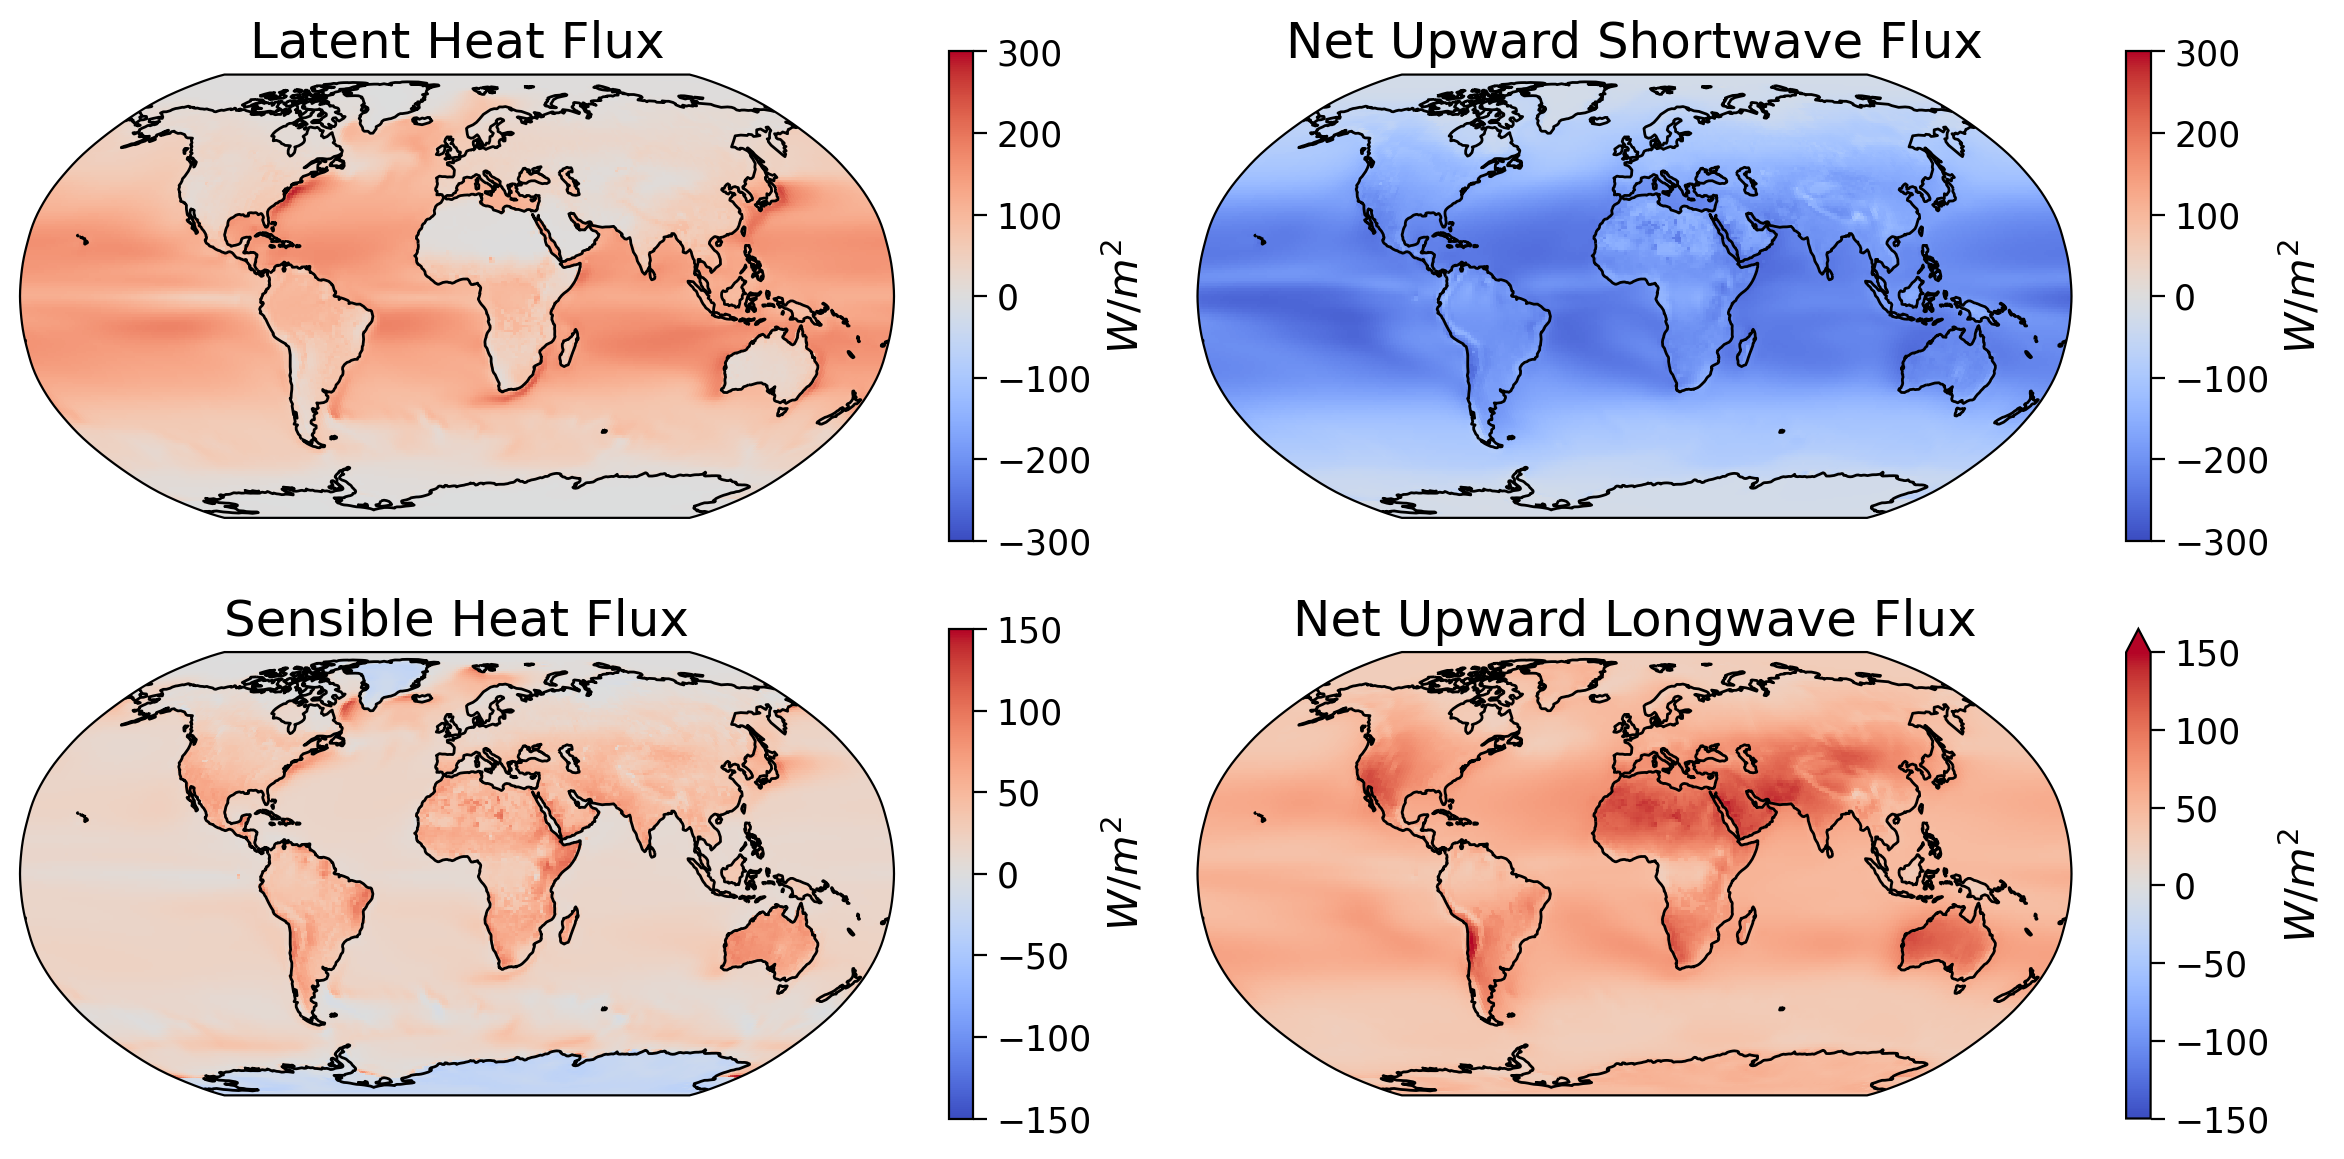

In [17]:
%matplotlib inline

fig, ([ax_latent, ax_shortwave], [ax_sensible, ax_longwave]) = plt.subplots(
    ncols=2, nrows=2, figsize=[12, 6], subplot_kw={"projection": ccrs.Robinson()}
)

# plot surface latent heat flux the first month of the historical period
hist_am_latent_heat_flux.plot(
    ax=ax_latent,
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    vmin=-300,
    vmax=300,
    cmap="coolwarm",
    robust=True,
    cbar_kwargs={"label": "$W/m^2$"},
)
ax_latent.coastlines()
ax_latent.set_title("Latent Heat Flux")

# Repeat for sensible heat flux
hist_am_sensible_heat_flux.plot(
    ax=ax_sensible,
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    vmin=-150,
    vmax=150,
    cmap="coolwarm",
    robust=True,
    cbar_kwargs={"label": "$W/m^2$"},
)
ax_sensible.coastlines()
ax_sensible.set_title("Sensible Heat Flux")

# Repeat for net shortwave radiative heat flux
hist_am_net_shortwave_heat_flux.plot(
    ax=ax_shortwave,
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    vmin=-300,
    vmax=300,
    cmap="coolwarm",
    robust=True,
    cbar_kwargs={"label": "$W/m^2$"},
)
ax_shortwave.coastlines()
ax_shortwave.set_title("Net Upward Shortwave Flux")

# Repeat for net longwave radiative heat flux
hist_am_net_longwave_heat_flux.plot(
    ax=ax_longwave,
    x="lon",
    y="lat",
    transform=ccrs.PlateCarree(),
    vmin=-150,
    vmax=150,
    cmap="coolwarm",
    robust=True,
    cbar_kwargs={"label": "$W/m^2$"},
)
ax_longwave.coastlines()
ax_longwave.set_title("Net Upward Longwave Flux")

## Questions 2: Climate Connection

1. What do you think causes the large spatial variations of the sensible heat flux between strong positive, weak, and strong negative fluxes? Consider different surface types in your answer.

In [18]:
# to_remove explanation

"""
1. Sensible heat fluxes depend on temperature differences between the Earth's surface and the surface air. The differences in the sensible heat flux seen here are largely caused by the different properties of the three main surface types: land, ocean, and ice. Land typically warms fast when exposed to insolation, the ocean has a much higher heat capacity so does not warm as much as land in response to insolation, and ice typically remains near zero degrees Celsius or colder. This means that land is often warmer than the surface air (strong positive sensible heat flux), the ocean and surface air often have a similar temperature (weak flux), and ice is often much cooler than surface air (strong negative flux)
""";

# Section 3: Surface Energy Budget by Latitude

We can also calculate a *zonal average* which allows us to compare the contributions of each of these fluxes to the net heat flux by latitude (similar to the plot in the last lecture that considered the RCE model prediction as a function of latitude).

To calculate a spatial average of a gridded data set, we often have to weight the data based on the size of the area it is describing. Fortunately, CESM data is on a regular latitude-longitude grid, which means that grid cells at a specific latitude have the same area as all the other grid cells at that latitude. This makes a zonal average easy, because at each latitude we can simply calculate the mean of all data at that latitude. 

*Note: Our averaging would have required area-weighting if we were calculating a global mean (as you did in previous Tutorials) or if you had irregularly gridded data (which we will encounter on W2D1)!*

In [19]:
# find the zonal means (.squeeze() removes singleton dimensions)
hist_azm_latent_heat_flux = hist_am_latent_heat_flux.mean(dim="x").squeeze()
hist_azm_sensible_heat_flux = hist_am_sensible_heat_flux.mean(dim="x").squeeze()
hist_azm_net_shortwave_flux = hist_am_net_shortwave_heat_flux.mean(dim="x").squeeze()
hist_azm_net_longwave_flux = hist_am_net_longwave_heat_flux.mean(dim="x").squeeze()
hist_azm_net_heat_flux = hist_am_net_heat_flux.mean(dim="x").squeeze()

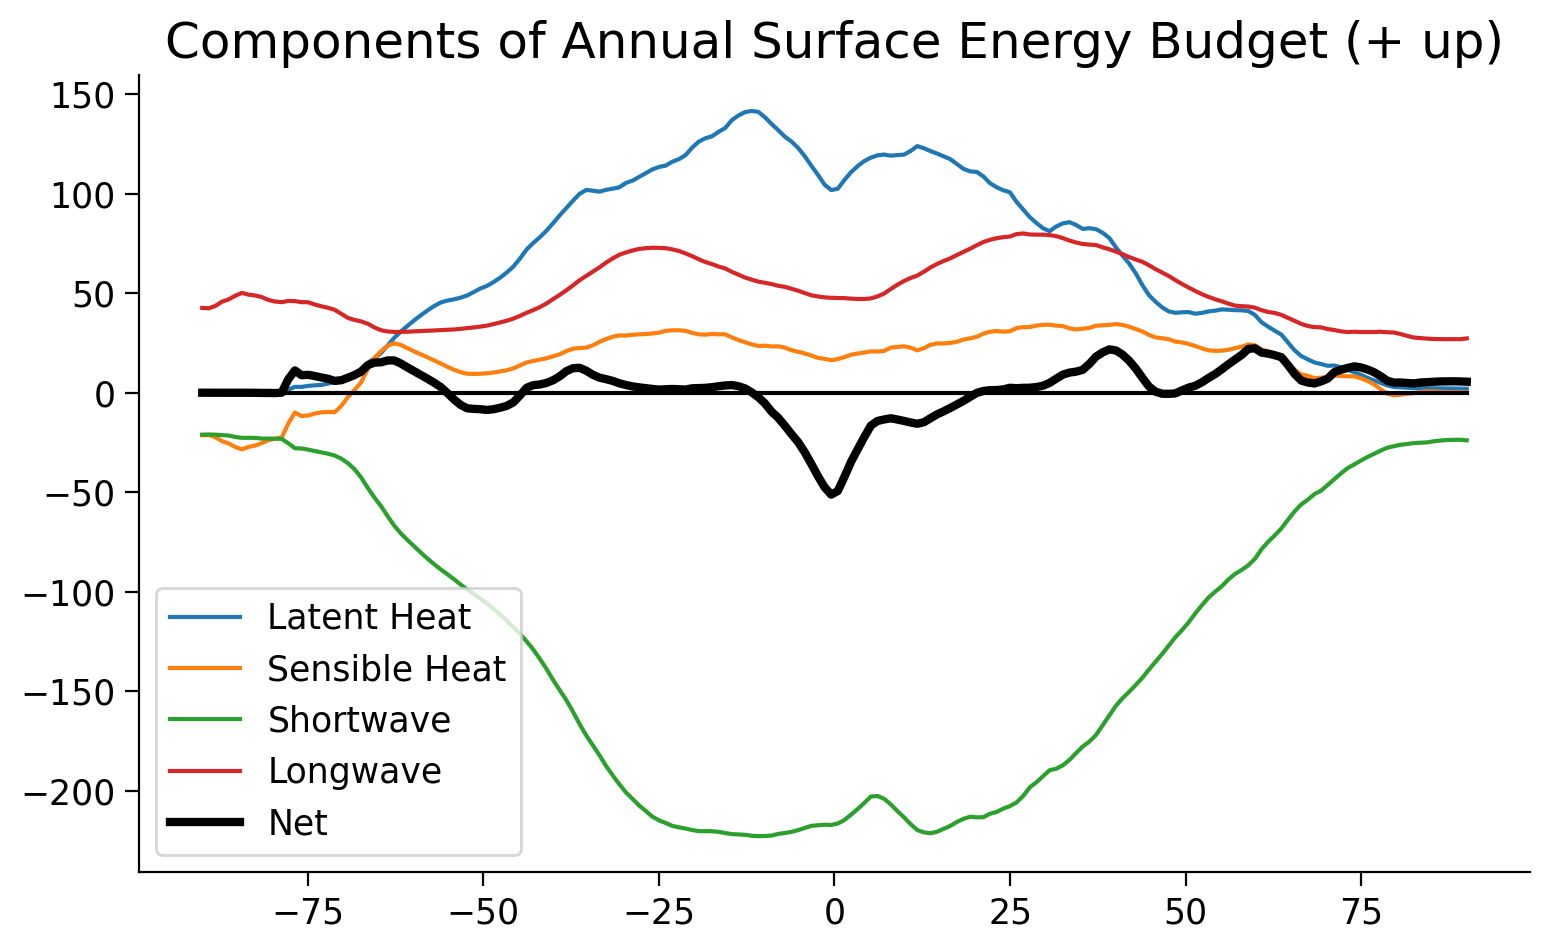

In [20]:
lat = hist_am_latent_heat_flux.lat[0, :]

fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(lat, hist_azm_latent_heat_flux, label="Latent Heat")
ax.plot(lat, hist_azm_sensible_heat_flux, label="Sensible Heat")
ax.plot(lat, hist_azm_net_shortwave_flux, label="Shortwave")
ax.plot(lat, hist_azm_net_longwave_flux, label="Longwave")
ax.plot(lat, hist_azm_net_heat_flux, lw=3, color="k", label="Net")
ax.plot(lat, 0 * lat, color="black")

ax.set_title("Components of Annual Surface Energy Budget (+ up)")
ax.legend()

## Questions 3: Climate Connection

1.  Describe the dominant balance in the tropics (30S to 30N).
2.  What about for the polar regions (above 60N and below 60S).
3.  What do you think causes the dip in latent heat near the equator?
4.  Is there symmetry in the longwave radiation in the high southern and northern latitudes? What about for sensible heat?

In [21]:
# to_remove explanation

"""
1. The tropics are warmed by shortwave radiation, which is balanced by cooling from latent heat (evaporation), longwave radiation (because the surface is warm) and a smaller sensible heat flux. There is a net negative imbalance, so other processes (e.g., lateral movement of heat) must transport surface heat away from the tropics.
2. In polar regions the shortwave incoming radiation and longwave outgoing radiation are the dominant balance in the Antarctic, while the Arctic also has a significant downward flux sensible heat (the atmosphere is typically warmer than the ice/ocean/land).
3. The intertropical convergence zone. This is region of significant cloud cover and precipitation created by surface air from both hemispheres converging near the Equator. This is also part of the reason the other fluxes also show dips near the Equator.
4. Longwave radiation is relatively symmetric. Some differences may be cause by hemispheric differences in relative land/ocean cover at each latitude. Sensible heat is quite symmetric at most latitudes (small changes due to surface type similar to the longwave radiation), but there is a significant negative sensible heat flux in the Arctic due to the combination of cold ice/ocean near the North pole, and relatively warm air (versus the Antarctic continent where air is consistently very cold)
""";

# Bonus Question: Climate Connection

5. Hypothetically, imagine this plot showed that the net heat flux was:
  - Negative 100 $W m^{-2}$ between 45$^oN$ to 45$^oS$ (i.e., 90 degrees of latitude centered on the Equator) and,
  - Positive 100 $W m^{-2}$ between 45$^oN$ to 90$^oN$ and between 45$^oS$ to 90$^oS$

  Would you expect Earth to warm, cool, or remain the same temperature? Why? 
  

In [22]:
# to_remove explanation

"""
5. Even though both latitude bands span 90 degrees, the poles of the Earth (highest 45 degrees of each hemisphere) cover a much smaller area than the Equatorial regions (lower 45 degrees of each hemisphere). Since the energy being entering or leaving the Earth system is the flux multiplied by the area, and the lower latitude region (negative/downward heat flux) covers a much larger area than the high latitude regions, the planet would be expected to warm in this situation.
""";

# Summary
In this tutorial, you learned to identify and access specific [CMIP6](https://wcrp-cmip.org/) datasets, which is vital for handling the vast datasets generated by climate models.  You analyzed data from a CESM simulation, focusing on how shortwave/longwave radiation, sensible and latent heat, contribute to the surface energy budget. This tutorial also explored the *zonal-mean* surface energy budget, elucidating how different surface heat flux components vary with latitude due to physical differences in air-surface conditions across regions.

# Resources

This tutorial uses data from the simulations conducted as part of the [CMIP6](https://wcrp-cmip.org/) multi-model ensemble. 

For examples on how to access and analyze data, please visit the [Pangeo Cloud CMIP6 Gallery](https://gallery.pangeo.io/repos/pangeo-gallery/cmip6/index.html) 

For more information on what CMIP is and how to access the data, please see this [page](https://github.com/ClimateMatchAcademy/course-content/blob/main/tutorials/CMIP/CMIP_resource_bank.md).